<a href="https://colab.research.google.com/github/paolaCaushi/anomalyDetectionWithTransferLearning/blob/AUTOENCODERS/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***VAE FOR ANOMALY DETECTION***

Number of rows (including header): 2670
Number of columns: 9

Sample of the data (first 5 rows):
   idAnomalia idConcentratore        dataAnomalia latitudine longitudine  \
0    18526375        SR013287 2023-05-26 12:16:28    39,2512      9,1338   
1    18699686        SR013287 2023-01-11 13:46:47    39,2585      9,0723   
2    19367851        SR013279 2022-10-10 08:42:46     40,124     18,3356   
3    21068660        SR013279 2022-03-26 07:52:15    41,2507     16,2203   
4    21076623        SR010385 2022-03-28 06:58:52    44,2287     12,0657   

       dataCoordinate        dataSegnalazione note  idPunto  Target  
0 2023-05-26 12:16:28 2015-04-22 14:24:01.353  NaN      NaN       0  
1 2023-01-11 13:46:47 2015-06-27 09:05:07.203  NaN  45267.0       0  
2 2022-10-10 08:42:46 2015-10-12 09:07:23.653  NaN  42607.0       0  
3 2022-03-26 07:52:15 2016-04-16 09:01:19.923  NaN  40981.0       0  
4 2022-03-28 06:58:52 2016-04-18 07:13:12.357  NaN      NaN       0  

Distribution of target va

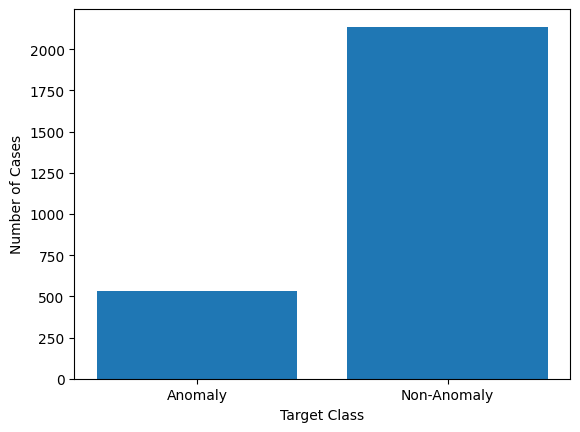

Epoch 1/100
54/54 [==============================] - 3s 18ms/step - loss: 0.5134 - val_loss: 0.2180
Epoch 2/100
54/54 [==============================] - 1s 14ms/step - loss: 0.0814 - val_loss: 0.0236
Epoch 3/100
54/54 [==============================] - 1s 15ms/step - loss: 0.0151 - val_loss: 0.0108
Epoch 4/100
54/54 [==============================] - 1s 14ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 5/100
54/54 [==============================] - 1s 14ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 6/100
54/54 [==============================] - 1s 14ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 7/100
54/54 [==============================] - 1s 14ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 8/100
54/54 [==============================] - 1s 15ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 9/100
54/54 [==============================] - 1s 18ms/step - loss: 0.0065 - val_loss: 0.0069
Epoch 10/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0063 - val_loss: 0.0070

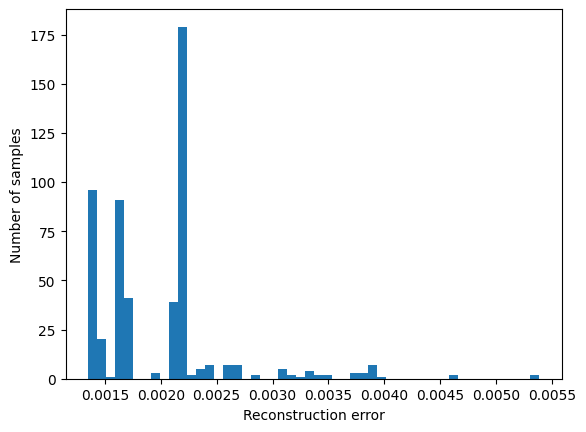

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Specify the path to the Excel file
data_file = "Anomalies_2021_2024.xlsx"

# Read data from Excel into a DataFrame
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Print basic information about the data
print(f"Number of rows (including header): {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Print a sample of the data (first 5 rows)
print("\nSample of the data (first 5 rows):")
print(df.head())

# Print the distribution of the target variable
anomaly_count = df['Target'].sum()
non_anomaly_count = df.shape[0] - anomaly_count
print(f"\nDistribution of target variable:")
print(f"--- Anomaly cases (idPunto NULL and note 12 or 6): {anomaly_count}")
print(f"--- Non-Anomaly cases: {non_anomaly_count}")

# Visualize the distribution with a bar chart
plt.bar(["Anomaly", "Non-Anomaly"], [anomaly_count, non_anomaly_count])
plt.xlabel("Target Class")
plt.ylabel("Number of Cases")
plt.show()

# Drop the 'idPunto' and 'note' columns and convert datetime columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X)

# Convert the sparse matrix to a dense array
X_preprocessed = X_preprocessed.toarray()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the VAE model
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(decoder_inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    reconstruction_loss = losses.binary_crossentropy(inputs, vae_outputs)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = reconstruction_loss + kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Build the VAE model
input_shape = X_train.shape[1]
latent_dim = 2  # Example latent dimension
vae, encoder, decoder = build_vae(input_shape, latent_dim)

# Train the VAE
history = vae.fit(X_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 90)  # 95th percentile can be considered as the threshold

# Identify anomalies
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


# **Me SMOTE**

Number of rows (including header): 2670
Number of columns: 9

Sample of the data (first 5 rows):
   idAnomalia idConcentratore        dataAnomalia latitudine longitudine  \
0    18526375        SR013287 2023-05-26 12:16:28    39,2512      9,1338   
1    18699686        SR013287 2023-01-11 13:46:47    39,2585      9,0723   
2    19367851        SR013279 2022-10-10 08:42:46     40,124     18,3356   
3    21068660        SR013279 2022-03-26 07:52:15    41,2507     16,2203   
4    21076623        SR010385 2022-03-28 06:58:52    44,2287     12,0657   

       dataCoordinate        dataSegnalazione note  idPunto  Target  
0 2023-05-26 12:16:28 2015-04-22 14:24:01.353  NaN      NaN       0  
1 2023-01-11 13:46:47 2015-06-27 09:05:07.203  NaN  45267.0       0  
2 2022-10-10 08:42:46 2015-10-12 09:07:23.653  NaN  42607.0       0  
3 2022-03-26 07:52:15 2016-04-16 09:01:19.923  NaN  40981.0       0  
4 2022-03-28 06:58:52 2016-04-18 07:13:12.357  NaN      NaN       0  

Distribution of target va

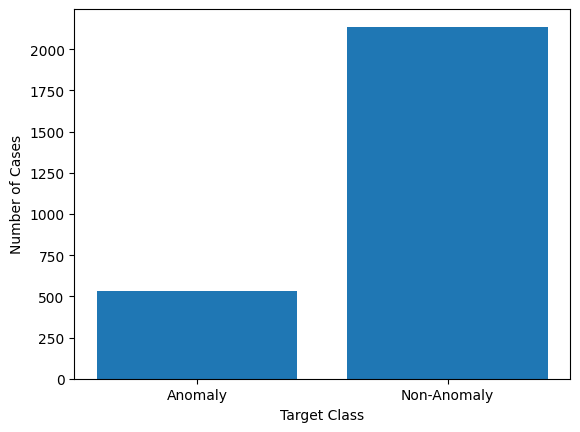

Epoch 1/200
54/54 [==============================] - 3s 21ms/step - loss: 0.5086 - val_loss: 0.2098
Epoch 2/200
54/54 [==============================] - 1s 26ms/step - loss: 0.0794 - val_loss: 0.0220
Epoch 3/200
54/54 [==============================] - 1s 26ms/step - loss: 0.0150 - val_loss: 0.0106
Epoch 4/200
54/54 [==============================] - 1s 24ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 5/200
54/54 [==============================] - 1s 16ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 6/200
54/54 [==============================] - 1s 17ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 7/200
54/54 [==============================] - 1s 17ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 8/200
54/54 [==============================] - 1s 18ms/step - loss: 0.0065 - val_loss: 0.0072
Epoch 9/200
54/54 [==============================] - 1s 16ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 10/200
54/54 [==============================] - 1s 18ms/step - loss: 0.0062 - val_loss: 0.0071

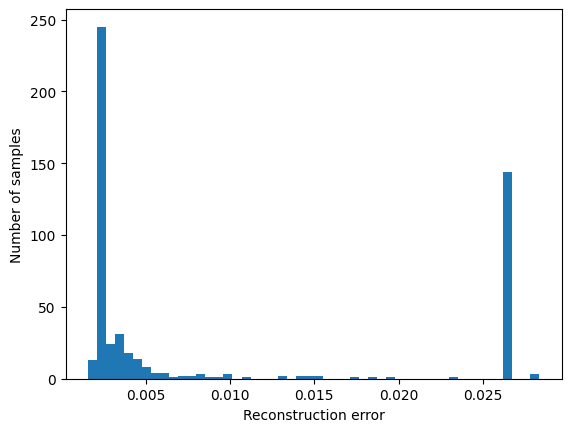

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Specify the path to the Excel file
data_file = "Anomalies_2021_2024.xlsx"

# Read data from Excel into a DataFrame
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Print basic information about the data
print(f"Number of rows (including header): {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Print a sample of the data (first 5 rows)
print("\nSample of the data (first 5 rows):")
print(df.head())

# Print the distribution of the target variable
anomaly_count = df['Target'].sum()
non_anomaly_count = df.shape[0] - anomaly_count
print(f"\nDistribution of target variable:")
print(f"--- Anomaly cases (idPunto NULL and note 12 or 6): {anomaly_count}")
print(f"--- Non-Anomaly cases: {non_anomaly_count}")

# Visualize the distribution with a bar chart
plt.bar(["Anomaly", "Non-Anomaly"], [anomaly_count, non_anomaly_count])
plt.xlabel("Target Class")
plt.ylabel("Number of Cases")
plt.show()

# Drop the 'idPunto' and 'note' columns and convert datetime columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X)

# Convert the sparse matrix to a dense array
X_preprocessed = X_preprocessed.toarray()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the VAE model with simplified architecture
def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=(input_shape,))

    # Encoder
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(decoder_inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    encoder = models.Model(inputs, [z_mean, z_log_var, z])
    decoder = models.Model(decoder_inputs, outputs)

    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs)

    reconstruction_loss = losses.binary_crossentropy(inputs, vae_outputs)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = reconstruction_loss + kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

# Build the VAE model with simplified architecture
input_shape = X_train.shape[1]
latent_dim = 2  # Using a smaller latent dimension
vae, encoder, decoder = build_vae(input_shape, latent_dim)

# Train the VAE
history = vae.fit(X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 85)  # Adjusting the threshold
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


TRYING TO FIX METRIS MEASURMENTS

Epoch 1/200
54/54 [==============================] - 3s 33ms/step - loss: -7417624.5000 - val_loss: -7147000.0000 - lr: 0.0010
Epoch 2/200
54/54 [==============================] - 1s 19ms/step - loss: -7711962.0000 - val_loss: -7430983.0000 - lr: 0.0010
Epoch 3/200
54/54 [==============================] - 1s 17ms/step - loss: -8017453.5000 - val_loss: -7715375.5000 - lr: 0.0010
Epoch 4/200
54/54 [==============================] - 1s 23ms/step - loss: -8327668.5000 - val_loss: -8025210.0000 - lr: 0.0010
Epoch 5/200
54/54 [==============================] - 1s 27ms/step - loss: -8652865.0000 - val_loss: -8329652.0000 - lr: 0.0010
Epoch 6/200
54/54 [==============================] - 2s 29ms/step - loss: -8984253.0000 - val_loss: -8648004.0000 - lr: 0.0010
Epoch 7/200
54/54 [==============================] - 1s 23ms/step - loss: -9326024.0000 - val_loss: -8975941.0000 - lr: 0.0010
Epoch 8/200
54/54 [==============================] - 1s 19ms/step - loss: -9677983.0000 - val_loss: -9315860.00

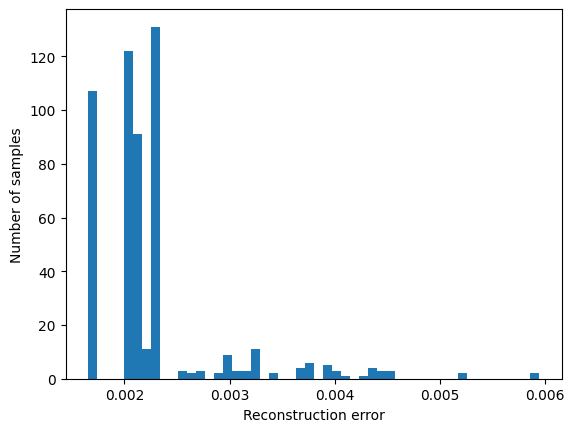

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the VAE
history = vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

# Predict on the test set
X_test_pred = vae.predict(X_test)

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_loss, 95)
y_pred = (reconstruction_loss > threshold).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the reconstruction error
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Number of samples")
plt.show()


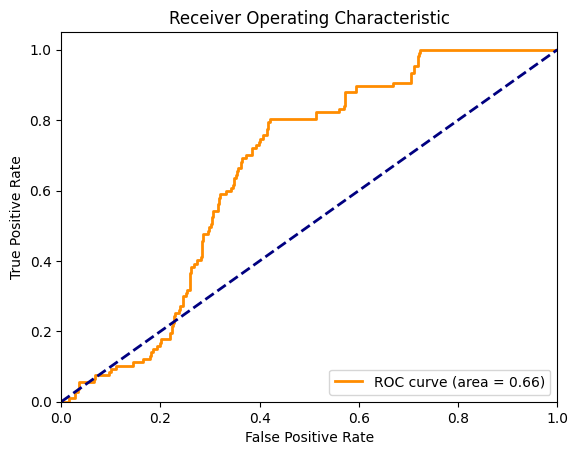


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.92      0.58      0.71       427
           1       0.32      0.79      0.46       107

    accuracy                           0.62       534
   macro avg       0.62      0.69      0.58       534
weighted avg       0.80      0.62      0.66       534



In [13]:
from sklearn.metrics import roc_curve, auc

# Calculate reconstruction error
reconstruction_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use the optimal threshold for anomaly detection
y_pred_optimal = (reconstruction_loss > optimal_threshold).astype(int)

# Print the classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

